In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [ ]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

device

device(type='cuda')

In [ ]:
transform  = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='/data',
                                        train=True,
                                        download=True,
                                        transform=transform)


Files already downloaded and verified


In [ ]:
testset = torchvision.datasets.ImageFolder(root = "/content/drive/MyDrive/Colab Notebooks/images/Statistical_Deep_Image",
                                           transform = transform)

In [ ]:
train_loader = DataLoader(trainset,
                          batch_size = 32,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(trainset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=2)

In [ ]:
classes = ('plane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck')

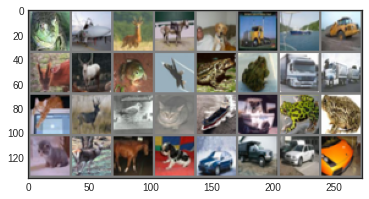

frog	plane	deer	horse	dog	truck	ship	truck	deer	deer	frog	plane	frog	frog	truck	truck	cat	deer	bird	cat	ship	ship	frog	frog	cat	deer	horse	dog	automobile	truck	automobile	automobile	


In [ ]:
def imshow(img):
  img= img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

dataiter= iter(train_loader)
images , labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("".join('{}\t'.format(classes[labels[j]]) for j in range(32)))

모델 넣기 

In [ ]:
class BasicBlock(nn.Module):
   def __init__(self, in_channels, out_channels, kernel_size=3):
       super(BasicBlock, self).__init__()


       # ❶ 합성곱층 정의
       self.c1 = nn.Conv2d(in_channels, out_channels, 
                           kernel_size=kernel_size, padding=1)
       self.c2 = nn.Conv2d(out_channels, out_channels, 
                           kernel_size=kernel_size, padding=1)

       self.downsample = nn.Conv2d(in_channels, out_channels, 
                                   kernel_size=1)
       
       # ❷ 배치 정규화층 정의
       self.bn1 = nn.BatchNorm2d(num_features=out_channels)
       self.bn2 = nn.BatchNorm2d(num_features=out_channels)

       self.relu = nn.ReLU()
   def forward(self, x):
       # ❸스킵 커넥션을 위해 초기 입력을 저장
       x_ = x

       x = self.c1(x)
       x = self.bn1(x)
       x = self.relu(x)
       x = self.c2(x)
       x = self.bn2(x)

       # ➍합성곱의 결과와 입력의 채널 수를 맞춤
       x_ = self.downsample(x_)

       # ➎합성곱층의 결과와 저장해놨던 입력값을 더해줌
       x += x_
       x = self.relu(x)

       return x


class ResNet(nn.Module):
   def __init__(self, num_classes=10):
       super(ResNet, self).__init__()


       # ❶ 기본 블록
       self.b1 = BasicBlock(in_channels=3, out_channels=64)
       self.b2 = BasicBlock(in_channels=64, out_channels=128)
       self.b3 = BasicBlock(in_channels=128, out_channels=256)


       # ❷ 풀링을 최댓값이 아닌 평균값으로
       self.pool = nn.AvgPool2d(kernel_size=2, stride=2) 

       # ❸ 분류기
       self.fc1 = nn.Linear(in_features=4096, out_features=2048)
       self.fc2 = nn.Linear(in_features=2048, out_features=512)
       self.fc3 = nn.Linear(in_features=512, out_features=num_classes)

       self.relu = nn.ReLU()
   def forward(self, x):
       # ❶ 기본 블록과 풀링층을 통과
       x = self.b1(x)
       x = self.pool(x)
       x = self.b2(x)
       x = self.pool(x)
       x = self.b3(x)
       x = self.pool(x)


       # ❷ 분류기의 입력으로 사용하기 위해 flatten
       x = torch.flatten(x, start_dim=1)

       # ❸ 분류기로 예측값 출력
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
       x = self.relu(x)
       x = self.fc3(x)

       return x



In [ ]:

net = ResNet(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(20):
  running_loss = 0.0
  
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs= net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 1000 ==999:
      print("Epoch: {},Batch : {}, Loss:{}".format(epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

Epoch: 1,Batch : 1000, Loss:0.35739493983983994
Epoch: 2,Batch : 1000, Loss:0.3567966661155224
Epoch: 3,Batch : 1000, Loss:0.3573868415355682
Epoch: 4,Batch : 1000, Loss:0.36041908302903175
Epoch: 5,Batch : 1000, Loss:0.3582128387391567


KeyboardInterrupt: ignored

pretrained 넣기


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

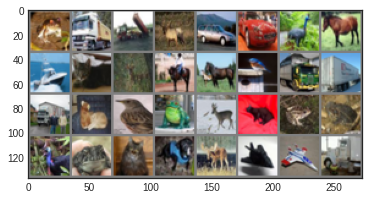

	frog	truck	truck	deer


In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(''.join('\t{}'.format(classes[labels[j]]) for j in range(4)))

In [ ]:
net = ResNet(num_classes=10).to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images.to(device))

In [ ]:
_, predicted = torch.max(outputs , 1)
print(''.join('\t{}'.format(classes[predicted[j]]) for j in range(4)))

	frog	truck	truck	deer


In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs= net(images)
    _, predicted = torch.max(outputs.data,1)
    total +=labels.size(0)
    correct += (predicted == labels).sum().item()

print(100* correct/total)

74.666


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs= net(images)
    _, predicted = torch.max(outputs.data,1)
    c= (predicted == labels).squeeze()
    for i in range(4):
      label= labels[i]
      class_correct[label]+= c[i].item()
      class_total[label]+= 1

for i in range(10):
  print("Accuracy of {} : {} %".format(classes[i],100* class_correct[i]/class_total[i]))

Accuracy of plane : 81.71334431630972 %
Accuracy of automobile : 81.76100628930817 %
Accuracy of bird : 68.34645669291339 %
Accuracy of cat : 40.1854714064915 %
Accuracy of deer : 59.905660377358494 %
Accuracy of dog : 69.15254237288136 %
Accuracy of frog : 85.66929133858268 %
Accuracy of horse : 88.13559322033899 %
Accuracy of ship : 79.15360501567397 %
Accuracy of truck : 92.78996865203762 %
